# SMS Spam Detection

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Importing the libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

## Load the data

In [ ]:
!pip show kaggle

Name: kaggle
Version: 1.5.16
Summary: Kaggle API
Home-page: https://github.com/Kaggle/kaggle-api
Author: Kaggle
Author-email: support@kaggle.com
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: bleach, certifi, python-dateutil, python-slugify, requests, six, tqdm, urllib3
Required-by: 


In [ ]:
from google.colab import files

uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d uciml/sms-spam-collection-dataset

100% 211k/211k [00:00<00:00, 537kB/s]
100% 211k/211k [00:00<00:00, 536kB/s]


In [ ]:
!unzip sms-spam-collection-dataset.zip -d /content/

Archive:  sms-spam-collection-dataset.zip
  inflating: /content/spam.csv       


In [ ]:
# Read the dataset
df = pd.read_csv("spam.csv", encoding="latin-1")

## Data Exploration (EDA)

In [ ]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
df = df.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])

In [ ]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df.count()

v1    5572
v2    5572
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [ ]:
df.describe()

,v1,v2
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


## Visualization

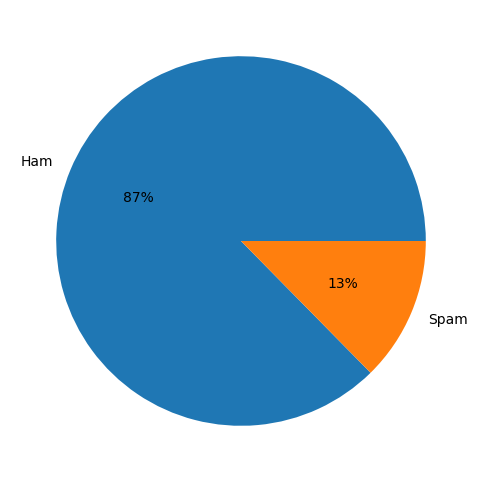

In [ ]:
# Plot pie chart to visualize
plt.figure(figsize=(8, 6))
kind_counts = df["v1"].value_counts()
plt.pie(kind_counts, labels=["Ham", "Spam"], autopct="%0.0f%%")
plt.show()

## Data Preprocessing

In [ ]:
# Check for null values
df.isnull().sum()

v1    0
v2    0
dtype: int64

In [ ]:
# Check for duplicate values
df.duplicated().sum()

403

In [ ]:
# Drop the duplicate values
df = df.drop_duplicates(subset=["v1", 'v2'])

In [ ]:
df.duplicated().sum()

0

In [ ]:
# Create a funciton to clean(preprocess) the text messages

def clean_text(text):
  # Converting our text simple format (removing extra unneccessary things)
  text = re.sub(r'<.*?>', '', text)
  text = re.sub(r'http\S+', '', text)
  text = re.sub(r'[^a-zA-Z0-9\s]', "", text)
  text = re.sub(r'@\S+', '', text)
  text = text.translate(str.maketrans('', '', string.punctuation))
  text = text.lower()


  # Tokenization
  words = word_tokenize(text)

  # Removing stop words
  stop_words = set(stopwords.words('english'))
  words = [word for word in words if word not in stop_words]

  # Stemming
  stemmer = PorterStemmer()
  words = [stemmer.stem(word) for word in words]

  # Join the cleaned words into a single string
  cleaned_text = ' '.join(words)

  return cleaned_text

In [ ]:
df["cleaned_message"] = df["v2"].apply(clean_text)

<ipython-input-69-712825b8e666>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["cleaned_message"] = df["v2"].apply(clean_text)


In [ ]:
# Label Encoding (Converting the categorical target labels into numerical labels)

# Initialize the LabelEncoder
encoder = LabelEncoder()

df["v1"] = encoder.fit_transform(df["v1"])

<ipython-input-51-40783e1b7605>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["v1"] = encoder.fit_transform(df["v1"])


In [ ]:
df.head()

,v1,v2,cleaned_message
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah dont think goe usf live around though


In [ ]:
# Splitting the dataset into training and testing set
vectorizer = TfidfVectorizer()
x = vectorizer.fit_transform(df["cleaned_message"])
y = df["v1"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
# Print the shapes of the splitted dataset
print(f"Shape of training features(x_train): {x_train.shape}")
print(f"Shape of testing features(x_test): {x_test.shape}")
print(f"Shape of training labels(y_train): {y_train.shape}")
print(f"Shape of testing labels(y_test): {y_test.shape}")

Shape of training features(x_train): (4135, 7962)
Shape of testing features(x_test): (1034, 7962)
Shape of training labels(y_train): (4135,)
Shape of testing labels(y_test): (1034,)


## Model Training

### Naive Bayes

In [ ]:
# Create and train the Naive Bayes model
naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(x_train, y_train)

MultinomialNB()

In [ ]:
# Make predictions on the test set
y_pred_nb = naive_bayes_model.predict(x_test)

In [ ]:
# Evaluating the model
accuracy_nb = accuracy_score(y_test, y_pred_nb)
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)
classification_rep_nb = classification_report(y_test, y_pred_nb)

# Displaying results
print(f"Accuracy: {accuracy_nb*100:.2f}%")
print("Confusion Matrix:\n", conf_matrix_nb)
print("Classification Report:\n", classification_rep_nb)

Accuracy: 96.03%
Confusion Matrix:
 [[889   0]
 [ 41 104]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       889
           1       1.00      0.72      0.84       145

    accuracy                           0.96      1034
   macro avg       0.98      0.86      0.91      1034
weighted avg       0.96      0.96      0.96      1034



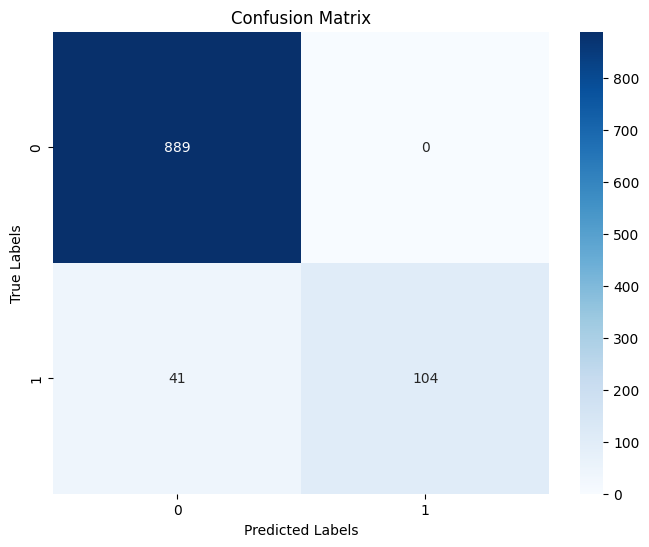

In [ ]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_nb, annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
# Sample text message for detection
sample_text = "Congratulations! You’ve won a $500 gift card to Target. Click here to claim your reward"

# Preprocess the text
cleaned_text = clean_text(sample_text)

# Vectorize the text
vectorized_text = vectorizer.transform([cleaned_text])

# Make predictions using the trained Naive Bayes model
predictions = naive_bayes_model.predict(vectorized_text)

# Print the result
if predictions[0] == 1:
    print("The message is predicted to be spam.")
else:
    print("The message is predicted to be not spam (ham).")


The message is predicted to be spam.


### Logistic Regression

In [ ]:
# Create and train the LogisticRegression
log_reg_model = LogisticRegression()
log_reg_model.fit(x_train, y_train)

LogisticRegression()

In [ ]:
# Make predictions on the test set
y_pred_log = log_reg_model.predict(x_test)

In [ ]:
# Evaluating the model
accuracy_log = accuracy_score(y_test, y_pred_log)
conf_matrix_log = confusion_matrix(y_test, y_pred_log)
classification_rep_log = classification_report(y_test, y_pred_log)

# Displaying results
print(f"Accuracy: {accuracy_log*100:.2f}%")
print("Confusion Matrix:\n", conf_matrix_log)
print("Classification Report:\n", classification_rep_log)

Accuracy: 94.58%
Confusion Matrix:
 [[884   5]
 [ 51  94]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       889
           1       0.95      0.65      0.77       145

    accuracy                           0.95      1034
   macro avg       0.95      0.82      0.87      1034
weighted avg       0.95      0.95      0.94      1034



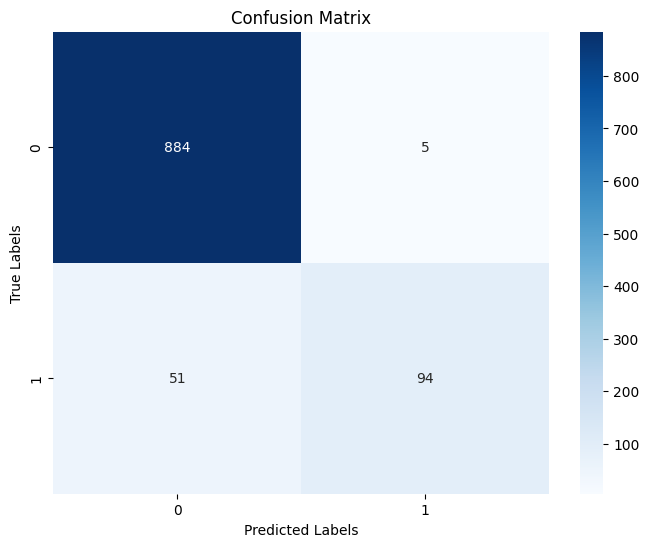

In [ ]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_log, annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
# Sample text message for detection
sample_text = "Hi!, long time no see. How's it going? Wanna hangout this weekend."

# Preprocess the text
cleaned_text = clean_text(sample_text)

# Vectorize the text
vectorized_text = vectorizer.transform([cleaned_text])

# Make predictions using the trained Naive Bayes model
predictions = log_reg_model.predict(vectorized_text)

# Print the result
if predictions[0] == 1:
    print("The message is predicted to be spam.")
else:
    print("The message is predicted to be not spam (ham).")

The message is predicted to be not spam (ham).


### SVM

In [ ]:
# Create and train svm model
svm_model = SVC(kernel='linear')
svm_model.fit(x_train, y_train)

SVC(kernel='linear')

In [ ]:
# Make predictions on the test set
y_pred_svm = svm_model.predict(x_test)

In [ ]:
# Evaluating the model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
classification_rep_svm = classification_report(y_test, y_pred_svm)

# Displaying results
print(f"Accuracy: {accuracy_svm*100:.2f}%")
print("Confusion Matrix:\n", conf_matrix_svm)
print("Classification Report:\n", classification_rep_svm)

Accuracy: 97.78%
Confusion Matrix:
 [[886   3]
 [ 20 125]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       889
           1       0.98      0.86      0.92       145

    accuracy                           0.98      1034
   macro avg       0.98      0.93      0.95      1034
weighted avg       0.98      0.98      0.98      1034



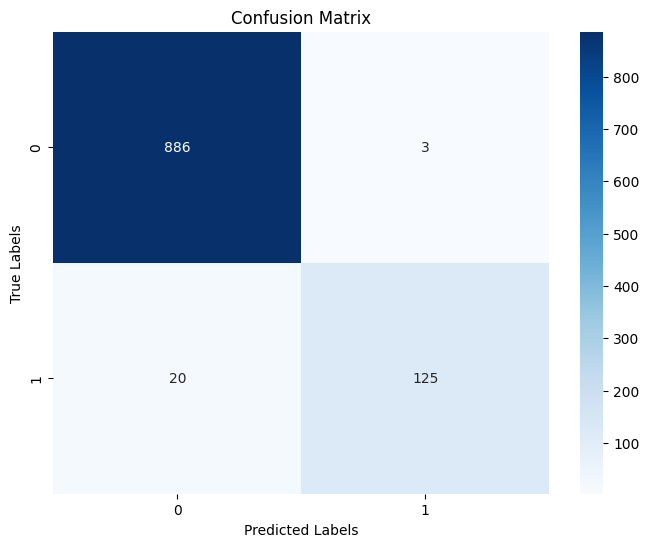

In [ ]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
# Sample text message for detection
sample_text = "you won free lottery of $100000 claim early"

# Preprocess the text
cleaned_text = clean_text(sample_text)

# Vectorize the text
vectorized_text = vectorizer.transform([cleaned_text])

# Make predictions using the trained Naive Bayes model
predictions = log_reg_model.predict(vectorized_text)

# Print the result
if predictions[0] == 1:
    print("The message is predicted to be spam.")
else:
    print("The message is predicted to be not spam (ham).")

The message is predicted to be spam.
